#MODELLING

3 genius with dataset 2000 pictures per genus. Different models tested with transfer learning, data augmentation

# Introduction


### Settings

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Settings
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

GDRIVE_MOUNT_POINT = '/content/drive'
PROJECT_DIR = GDRIVE_MOUNT_POINT + '/MyDrive/Mushroom_project' 
PY_LIB_DIR = PROJECT_DIR + '/src/lib'
SRC_DIR = PROJECT_DIR + '/datasource/mushroomObserver/dataframes/clean'

WORK_DIR = "/content/drive/MyDrive/work/Oliv"
IMG_DIR = WORK_DIR + "/images_clean"

MODEL_DIR = WORK_DIR + "/saved_model/3 genus_2k/"


### Import libraries

In [ ]:
# Importing standard libraries
#
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import seaborn as sns

from keras import backend as K
from keras.preprocessing import image
from tensorflow.keras import models

import cv2
import matplotlib.cm as cm

from IPython.display import Image, display

import random

from sklearn import metrics
from sklearn.model_selection import train_test_split

 

In [ ]:
# Optional - Pre-requisites 
#
# Mounting Google drive if not already done
if not os.path.isdir(GDRIVE_MOUNT_POINT):
  drive.mount(GDRIVE_MOUNT_POINT)


Mounted at /content/drive


### Loading Data

In [ ]:
df_genus = pd.read_csv( \
      filepath_or_buffer = WORK_DIR + '/' + "df_genus_2k_clean.csv"
   ,  sep = ','
   ,  header = 0
)

In [ ]:
df_genus.shape

(27080, 39)

In [ ]:
df_genus = pd.read_csv( \
      filepath_or_buffer = WORK_DIR + '/' + "df_genus_2k_clean.csv"
   ,  sep = ','
   ,  header = 0
)

#specify image link within Google Drive
#for i in range(len(df_genus)):
#  df_genus.loc[i,"img_path"]= WORK_DIR + "/" + df_genus.loc[i,"taxon_name"] + "/" + str(int(df_genus.loc[i,"image_id"]))+".jpg"


#filter specific nb of genus for test purposes

filtre_genus=df_genus.taxon_name.value_counts().index[:3]

t= df_genus.shape
df_genus=df_genus[df_genus["taxon_name"].isin(filtre_genus)].reset_index()

#Prepare train and test sets
X= df_genus[df_genus["taxon_name"].isin(filtre_genus)][["img_path","taxon_name"]]

#split the dataset between 80% train, 20% validation and 10% test)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
X_train, X_val= train_test_split(X_train, test_size=0.125,  random_state=1)

print("shape : ", t)
print("shape X genus: ", X.shape)
print("shape train: ", X_train.shape)
print("shape test:", X_test.shape)
print("shape valid: ", X_val.shape)

X_train.reset_index(drop=True, inplace=True)
X_train.head()

shape :  (27080, 39)
shape X genus:  (5725, 2)
shape train:  (4007, 2)
shape test: (1145, 2)
shape valid:  (573, 2)


,img_path,taxon_name
0,/content/drive/MyDrive/work/Oliv/images_clean/...,Armillaria
1,/content/drive/MyDrive/work/Oliv/images_clean/...,Amanita
2,/content/drive/MyDrive/work/Oliv/images_clean/...,Amanita
3,/content/drive/MyDrive/work/Oliv/images_clean/...,Amanita
4,/content/drive/MyDrive/work/Oliv/images_clean/...,Armillaria


In [ ]:
df_genus.taxon_name.value_counts()

Amanita       1927
Armillaria    1899
Hygrocybe     1899
Name: taxon_name, dtype: int64

In [ ]:
#Global Configuration

epochs= 100

batch_size=32


#Efficient Net B0

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=None

learning_rate=0.01


In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.


In [ ]:
#optionnal : visualise 5 pictures
mushroom=[next(train_generator) for i in range(0,5)]
fig,ax=plt.subplots(1,5, figsize=(15,6))
print("Genre: ", [item[1][0] for item in mushroom])
for i in range(0,5):
    ax[i].imshow(mushroom[i][0][0].astype("uint8"))
    ax[i].axis("off")


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)    #preprocessing treatments included in the model 

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#compile  
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit

reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = tf.math.exp(-0.5)
   , patience = 5  
   , min_lr = 0.0000
   , verbose = 1
)


callback = [reduceLEarningRate_clbck, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)
# on arrive à 89%

Epoch 1/100
126/126 [==============================] - 43s 285ms/step - loss: 0.9995 - accuracy: 0.7095 - val_loss: 0.8604 - val_accuracy: 0.7616
Epoch 2/100
126/126 [==============================] - 33s 263ms/step - loss: 0.5554 - accuracy: 0.7896 - val_loss: 0.4073 - val_accuracy: 0.8489
Epoch 3/100
126/126 [==============================] - 35s 275ms/step - loss: 0.5088 - accuracy: 0.8101 - val_loss: 0.3307 - val_accuracy: 0.8760
Epoch 4/100
126/126 [==============================] - 33s 263ms/step - loss: 0.4740 - accuracy: 0.8213 - val_loss: 0.4268 - val_accuracy: 0.8367
Epoch 5/100
126/126 [==============================] - 34s 271ms/step - loss: 0.4647 - accuracy: 0.8183 - val_loss: 0.3433 - val_accuracy: 0.8769
Epoch 6/100
126/126 [==============================] - 33s 261ms/step - loss: 0.4259 - accuracy: 0.8390 - val_loss: 0.2959 - val_accuracy: 0.8969
Epoch 7/100
126/126 [==============================] - 34s 273ms/step - loss: 0.4595 - accuracy: 0.8313 - val_loss: 0.3200 -

18/18 [==============================] - 4s 205ms/step - loss: 0.2379 - accuracy: 0.9075


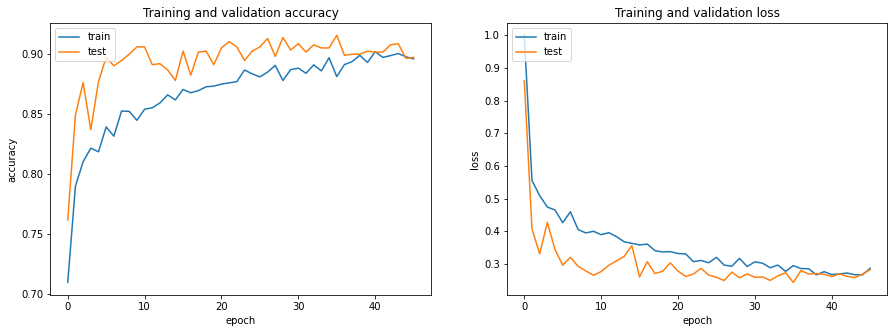

36/36 [==============================] - 8s 197ms/step
              precision    recall  f1-score   support

     Amanita       0.88      0.93      0.91       384
  Armillaria       0.93      0.89      0.91       376
   Hygrocybe       0.93      0.93      0.93       385

    accuracy                           0.92      1145
   macro avg       0.92      0.92      0.92      1145
weighted avg       0.92      0.92      0.92      1145



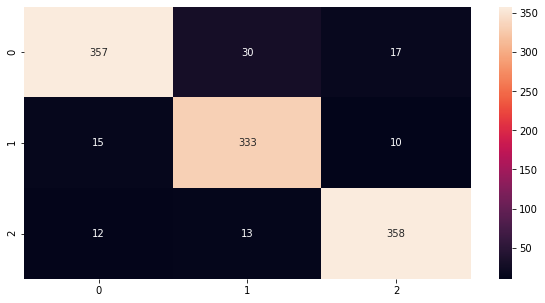

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "ENetB0.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B1


In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=None

learning_rate=0.01

In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable= False
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

#on arrive à 64%

Epoch 1/100
126/126 [==============================] - 44s 289ms/step - loss: 1.1643 - accuracy: 0.6798 - val_loss: 1.5596 - val_accuracy: 0.7694
Epoch 2/100
126/126 [==============================] - 34s 274ms/step - loss: 0.6487 - accuracy: 0.7702 - val_loss: 0.3938 - val_accuracy: 0.8716
Epoch 3/100
126/126 [==============================] - 33s 261ms/step - loss: 0.5578 - accuracy: 0.8013 - val_loss: 0.3804 - val_accuracy: 0.8943
Epoch 4/100
126/126 [==============================] - 35s 275ms/step - loss: 0.5147 - accuracy: 0.8191 - val_loss: 0.3058 - val_accuracy: 0.8934
Epoch 5/100
126/126 [==============================] - 33s 260ms/step - loss: 0.4899 - accuracy: 0.8248 - val_loss: 0.3328 - val_accuracy: 0.8917
Epoch 6/100
126/126 [==============================] - 35s 275ms/step - loss: 0.4619 - accuracy: 0.8258 - val_loss: 0.3359 - val_accuracy: 0.8908
Epoch 7/100
126/126 [==============================] - 33s 262ms/step - loss: 0.4513 - accuracy: 0.8348 - val_loss: 0.3753 -

18/18 [==============================] - 4s 217ms/step - loss: 0.2256 - accuracy: 0.9005


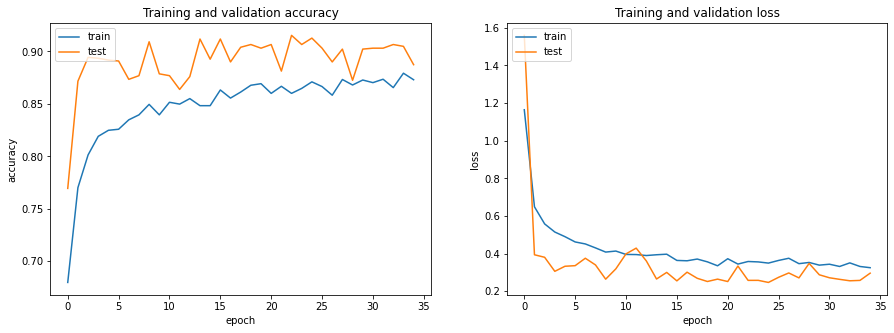

36/36 [==============================] - 9s 214ms/step
              precision    recall  f1-score   support

     Amanita       0.88      0.94      0.91       384
  Armillaria       0.92      0.89      0.90       376
   Hygrocybe       0.95      0.90      0.93       385

    accuracy                           0.91      1145
   macro avg       0.91      0.91      0.91      1145
weighted avg       0.91      0.91      0.91      1145



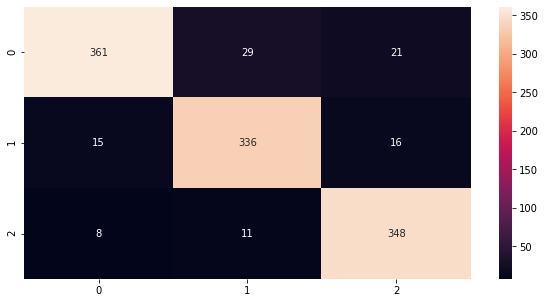

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "ENetB1.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B2

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(260,260)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs) 

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)
# on arrive à %

Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
Epoch 1/100
126/126 [==============================] - 46s 299ms/step - loss: 1.1686 - accuracy: 0.6933 - val_loss: 0.7127 - val_accuracy: 0.8629
Epoch 2/100
126/126 [==============================] - 37s 293ms/step - loss: 0.6607 - accuracy: 0.7724 - val_loss: 0.6277 - val_accuracy: 0.8105
Epoch 3/100
126/126 [==============================] - 36s 283ms/step - loss: 0.5689 - accuracy: 0.7981 - val_loss: 0.8072 - val_accuracy: 0.7738
Epoch 4/100
126/126 [==============================] - 37s 292ms/step - loss: 0.4889 - accuracy: 0.8191 - val_loss: 0.3903 - val_accuracy: 0.8454
Epoch 5/100
126/126 [==============================] - 36s 284ms/step - loss: 0.4661 - accuracy: 0.8288 - val_loss: 0.4468 - val_accuracy: 0.8690
Epoch 6/100
126/126 [==============================] - 36s 288ms/step - loss: 0.4508 - a

18/18 [==============================] - 4s 218ms/step - loss: 0.2499 - accuracy: 0.9197


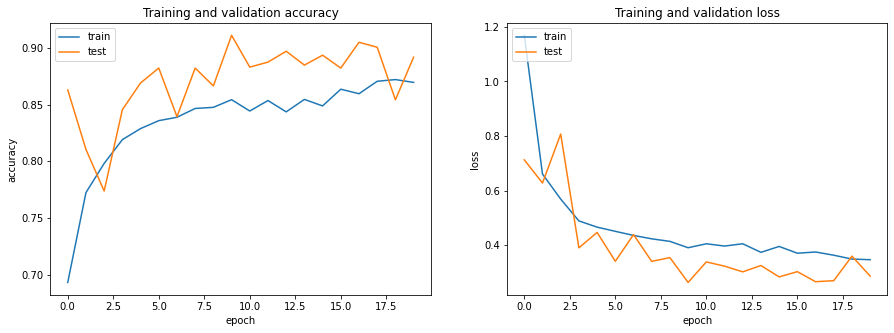

36/36 [==============================] - 9s 212ms/step
              precision    recall  f1-score   support

     Amanita       0.91      0.90      0.90       384
  Armillaria       0.91      0.90      0.91       376
   Hygrocybe       0.91      0.93      0.92       385

    accuracy                           0.91      1145
   macro avg       0.91      0.91      0.91      1145
weighted avg       0.91      0.91      0.91      1145



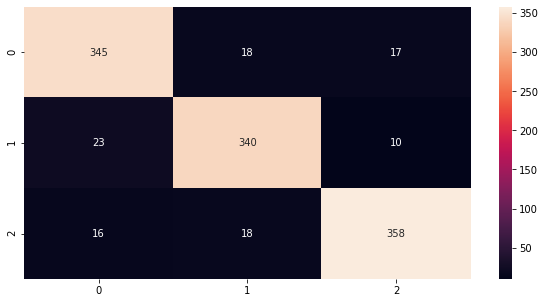

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "ENetB2.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B3

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(300,300)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])


history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
43941888/43941136 [==============================] - 2s 0us/step
Epoch 1/100
126/126 [==============================] - 53s 345ms/step - loss: 1.1097 - accuracy: 0.6968 - val_loss: 1.3740 - val_accuracy: 0.7642
Epoch 2/100
126/126 [==============================] - 41s 328ms/step - loss: 0.6043 - accuracy: 0.7904 - val_loss: 0.5649 - val_accuracy: 0.8550
Epoch 3/100
126/126 [==============================] - 40s 317ms/step - loss: 0.5316 - accuracy: 0.8161 - val_loss: 0.4504 - val_accuracy: 0.8681
Epoch 4/100
126/126 [==============================] - 40s 315ms/step - loss: 0.4746 - accuracy: 0.8343 - val_loss: 0.2973 - val_accuracy: 0.9074
Epoch 5/100
126/126 [==============================] - 39s 309ms/step - loss: 0.4552 - accuracy: 0.8388 - val_loss: 0.3353 - val_accuracy: 0.8865
Epoch 6/100
126/126 [==

18/18 [==============================] - 4s 233ms/step - loss: 0.2606 - accuracy: 0.9092


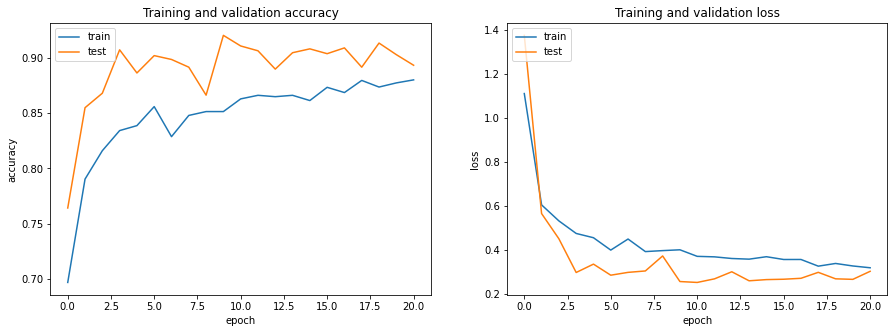

36/36 [==============================] - 10s 223ms/step
              precision    recall  f1-score   support

     Amanita       0.89      0.92      0.90       384
  Armillaria       0.94      0.87      0.90       376
   Hygrocybe       0.91      0.95      0.93       385

    accuracy                           0.91      1145
   macro avg       0.91      0.91      0.91      1145
weighted avg       0.91      0.91      0.91      1145



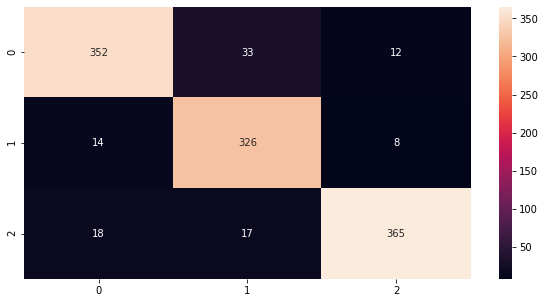

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "ENetB3.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B4

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(380,380)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])


history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
71688192/71686520 [==============================] - 2s 0us/step
Epoch 1/100
126/126 [==============================] - 62s 406ms/step - loss: 1.2080 - accuracy: 0.6751 - val_loss: 0.8623 - val_accuracy: 0.8341
Epoch 2/100
126/126 [==============================] - 47s 373ms/step - loss: 0.6298 - accuracy: 0.7921 - val_loss: 0.4307 - val_accuracy: 0.8865
Epoch 3/100
126/126 [==============================] - 47s 373ms/step - loss: 0.5244 - accuracy: 0.8071 - val_loss: 0.5236 - val_accuracy: 0.8594
Epoch 4/100
126/126 [==============================] - 46s 366ms/step - loss: 0.4890 - accuracy: 0.8251 - val_loss: 0.4277 - val_accuracy: 0.8629
Epoch 5/100
126/126 [==============================] - 48s 379ms/step - loss: 0.4486 - accuracy: 0.8405 - val_loss: 0.4432 - val_accuracy: 0.8472
Epoch 6/100
126/126 [==

18/18 [==============================] - 5s 287ms/step - loss: 0.1888 - accuracy: 0.9267


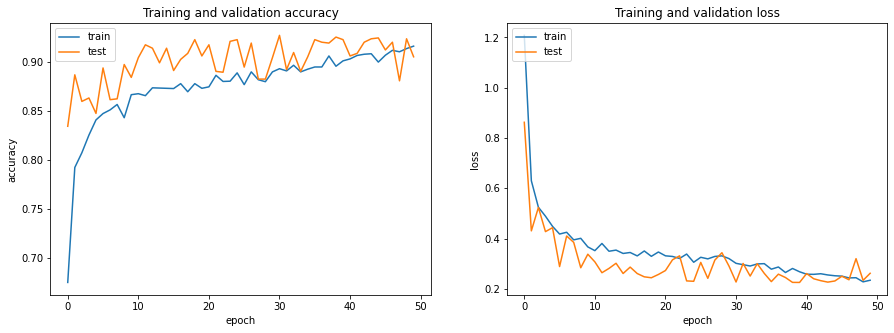

36/36 [==============================] - 12s 261ms/step
              precision    recall  f1-score   support

     Amanita       0.88      0.93      0.90       384
  Armillaria       0.95      0.89      0.92       376
   Hygrocybe       0.95      0.94      0.95       385

    accuracy                           0.92      1145
   macro avg       0.92      0.92      0.92      1145
weighted avg       0.92      0.92      0.92      1145



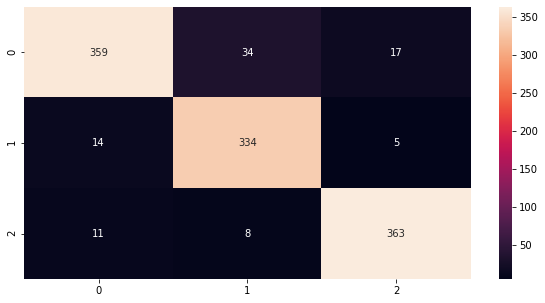

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "ENetB4.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B5


In [ ]:
#Model Configuration

IMG_SIZE=(456,456)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB5(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable= False
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)


Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
115269632/115263384 [==============================] - 3s 0us/step
Epoch 1/100
126/126 [==============================] - 75s 493ms/step - loss: 1.1076 - accuracy: 0.7080 - val_loss: 0.6827 - val_accuracy: 0.8847
Epoch 2/100
126/126 [==============================] - 59s 464ms/step - loss: 0.5741 - accuracy: 0.8036 - val_loss: 0.3203 - val_accuracy: 0.9048
Epoch 3/100
126/126 [==============================] - 58s 461ms/step - loss: 0.4581 - accuracy: 0.8393 - val_loss: 0.3609 - val_accuracy: 0.8978
Epoch 4/100
126/126 [==============================] - 60s 476ms/step - loss: 0.4211 - accuracy: 0.8565 - val_loss: 0.3310 - val_accuracy: 0.9039
Epoch 5/100
126/126 [==============================] - 59s 464ms/step - loss: 0.4131 - accuracy: 0.8470 - val_loss: 0.3276 - val_accuracy: 0.8969
Epoch 6/100
126/126 [

18/18 [==============================] - 6s 348ms/step - loss: 0.1788 - accuracy: 0.9232


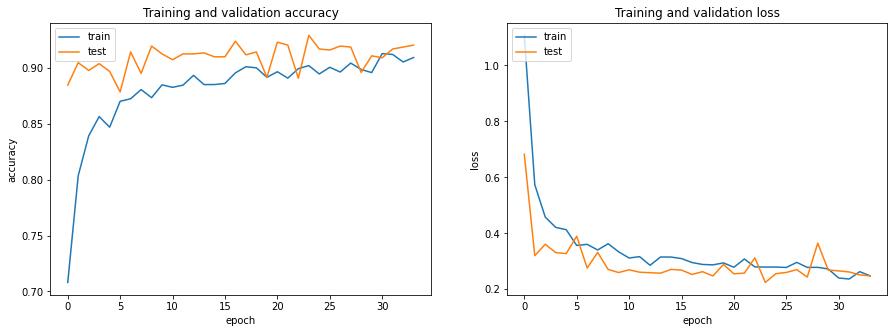

36/36 [==============================] - 13s 297ms/step
              precision    recall  f1-score   support

     Amanita       0.94      0.92      0.93       384
  Armillaria       0.93      0.92      0.92       376
   Hygrocybe       0.93      0.94      0.93       385

    accuracy                           0.93      1145
   macro avg       0.93      0.93      0.93      1145
weighted avg       0.93      0.93      0.93      1145



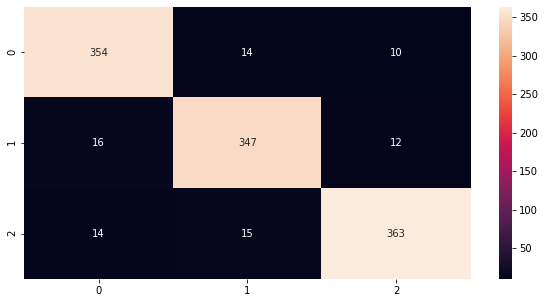

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)


In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "ENetB5.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B6

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(528,528)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB6(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])


history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
165240832/165234480 [==============================] - 5s 0us/step
Epoch 1/100
126/126 [==============================] - 98s 660ms/step - loss: 1.0719 - accuracy: 0.7048 - val_loss: 1.2271 - val_accuracy: 0.8000
Epoch 2/100
126/126 [==============================] - 79s 622ms/step - loss: 0.5479 - accuracy: 0.8123 - val_loss: 0.5198 - val_accuracy: 0.8445
Epoch 3/100
126/126 [==============================] - 79s 624ms/step - loss: 0.5154 - accuracy: 0.8198 - val_loss: 0.3732 - val_accuracy: 0.8769
Epoch 4/100
126/126 [==============================] - 79s 623ms/step - loss: 0.4384 - accuracy: 0.8425 - val_loss: 0.2695 - val_accuracy: 0.9092
Epoch 5/100
126/126 [==============================] - 79s 625ms/step - loss: 0.4272 - accuracy: 0.8495 - val_loss: 0.2669 - val_accuracy: 0.9031
Epoch 6/100
126/126 [

18/18 [==============================] - 9s 471ms/step - loss: 0.1764 - accuracy: 0.9424


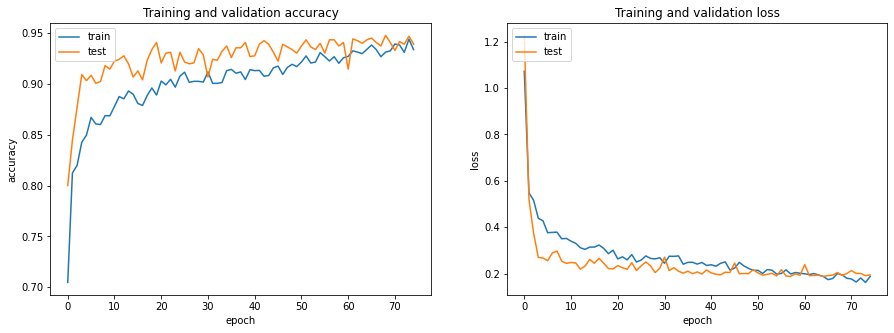

36/36 [==============================] - 19s 447ms/step
              precision    recall  f1-score   support

     Amanita       0.92      0.96      0.94       384
  Armillaria       0.95      0.93      0.94       376
   Hygrocybe       0.96      0.94      0.95       385

    accuracy                           0.94      1145
   macro avg       0.94      0.94      0.94      1145
weighted avg       0.94      0.94      0.94      1145



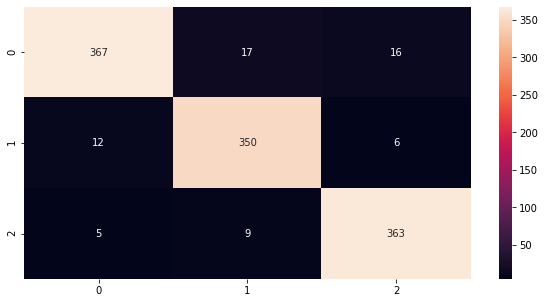

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "ENetB6.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B7

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(600,600)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
258080768/258076736 [==============================] - 5s 0us/step
Epoch 1/100
126/126 [==============================] - 156s 1s/step - loss: 1.1029 - accuracy: 0.7048 - val_loss: 0.9676 - val_accuracy: 0.8349
Epoch 2/100
126/126 [==============================] - 131s 1s/step - loss: 0.6289 - accuracy: 0.8086 - val_loss: 0.7680 - val_accuracy: 0.8166
Epoch 3/100
126/126 [==============================] - 132s 1s/step - loss: 0.4978 - accuracy: 0.8218 - val_loss: 0.3405 - val_accuracy: 0.8996
Epoch 4/100
126/126 [==============================] - 131s 1s/step - loss: 0.4449 - accuracy: 0.8448 - val_loss: 0.3058 - val_accuracy: 0.9031
Epoch 5/100
126/126 [==============================] - 132s 1s/step - loss: 0.4104 - accuracy: 0.8485 - val_loss: 0.3634 - val_accuracy: 0.8664
Epoch 6/100
126/126 [==========

18/18 [==============================] - 14s 784ms/step - loss: 0.1521 - accuracy: 0.9459


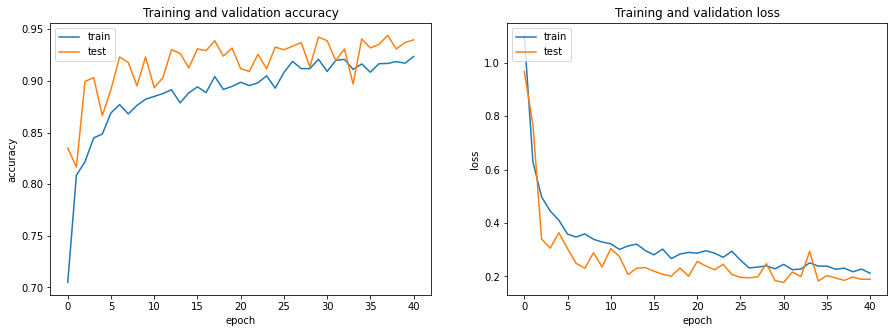

36/36 [==============================] - 31s 759ms/step
              precision    recall  f1-score   support

     Amanita       0.92      0.94      0.93       384
  Armillaria       0.94      0.93      0.94       376
   Hygrocybe       0.96      0.94      0.95       385

    accuracy                           0.94      1145
   macro avg       0.94      0.94      0.94      1145
weighted avg       0.94      0.94      0.94      1145



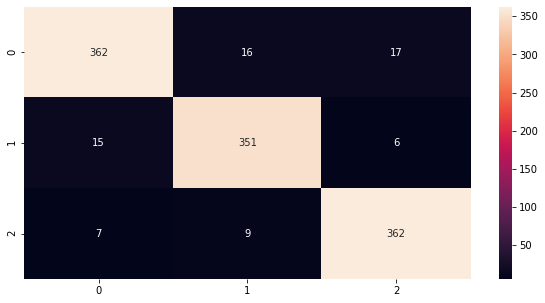

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "ENetB7.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# VGG16

We start with a basic VGG16 

In [ ]:
#TEST TEST

IMG_SIZE=(224,224)

pp_input=tf.keras.applications.vgg16.preprocess_input

learning_rate=0.01

epochs=100
batch_size=32


datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pp_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="", 
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=x)
for layer in base_model.layers:
    layer.trainable= False
#build modelb
x = base_model(x, training=False) 
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = tf.math.exp(-0.5)
   , patience = 5  
   , min_lr = 0.0000
   , verbose = 1
)

callback = [reduceLEarningRate_clbck, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
Epoch 1/100
126/126 [==============================] - 39s 292ms/step - loss: 1.0599 - accuracy: 0.7143 - val_loss: 1.1189 - val_accuracy: 0.8341
Epoch 2/100
126/126 [==============================] - 37s 296ms/step - loss: 0.6390 - accuracy: 0.7844 - val_loss: 0.8084 - val_accuracy: 0.8489
Epoch 3/100
126/126 [==============================] - 36s 283ms/step - loss: 0.5626 - accuracy: 0.7976 - val_loss: 0.6535 - val_accuracy: 0.8218
Epoch 4/100
126/126 [==============================] - 37s 296ms/step - loss: 0.5205 - accuracy: 0.8051 - val_loss: 0.5374 - val_accuracy: 0.8410
Epoch 5/100
126/126 [==============================] - 37s 296ms/step - loss: 0.4559 - accuracy: 0.8256 - val_loss: 0.4793 - val_accuracy: 0.8585
Epoch 6/100
126/126 [==============================] - 37s 291ms/step - loss: 0.4780 - a

18/18 [==============================] - 4s 222ms/step - loss: 0.2391 - accuracy: 0.9162


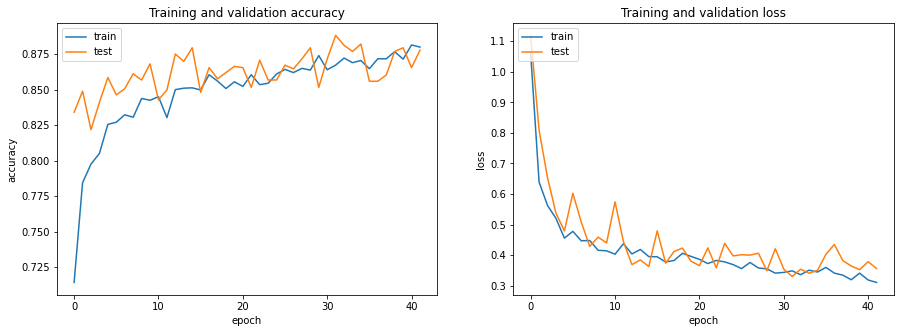

36/36 [==============================] - 8s 212ms/step
              precision    recall  f1-score   support

     Amanita       0.85      0.88      0.86       384
  Armillaria       0.89      0.88      0.89       376
   Hygrocybe       0.93      0.90      0.91       385

    accuracy                           0.89      1145
   macro avg       0.89      0.89      0.89      1145
weighted avg       0.89      0.89      0.89      1145



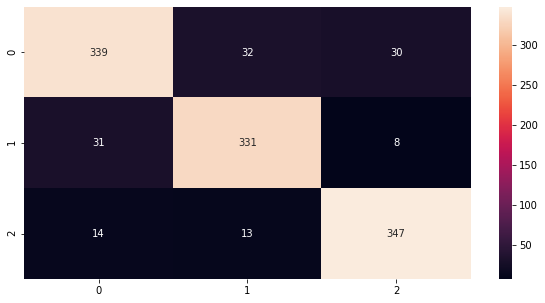

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)


In [ ]:
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "VGG16.h5")

#VGG19

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

pp_input=tf.keras.applications.vgg19.preprocess_input

#CE LEARNING RATE EST PLUS ADAPTE POUR VGG
learning_rate=0.01

epochs=100

In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pp_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="", 
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)
base_model = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_tensor=x)
for layer in base_model.layers:
    layer.trainable= False
#build modelb
x = base_model(x) 
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

# => on arrive à % 

80142336/80134624 [==============================] - 2s 0us/step
Epoch 1/100
126/126 [==============================] - 40s 307ms/step - loss: 1.0380 - accuracy: 0.7108 - val_loss: 2.9571 - val_accuracy: 0.7459
Epoch 2/100
126/126 [==============================] - 37s 290ms/step - loss: 0.6553 - accuracy: 0.7769 - val_loss: 0.6406 - val_accuracy: 0.8393
Epoch 3/100
126/126 [==============================] - 38s 304ms/step - loss: 0.5971 - accuracy: 0.7889 - val_loss: 0.5735 - val_accuracy: 0.8507
Epoch 4/100
126/126 [==============================] - 37s 296ms/step - loss: 0.4942 - accuracy: 0.8126 - val_loss: 0.5215 - val_accuracy: 0.8541
Epoch 5/100
126/126 [==============================] - 38s 305ms/step - loss: 0.4909 - accuracy: 0.8153 - val_loss: 0.4139 - val_accuracy: 0.8611
Epoch 6/100
126/126 [==============================] - 38s 299ms/step - loss: 0.4802 - accuracy: 0.8186 - val_loss: 0.5002 - val_accuracy: 0.8437
Epoch 7/100
126/126 [==============================] - 38s 

18/18 [==============================] - 4s 227ms/step - loss: 0.2824 - accuracy: 0.8918


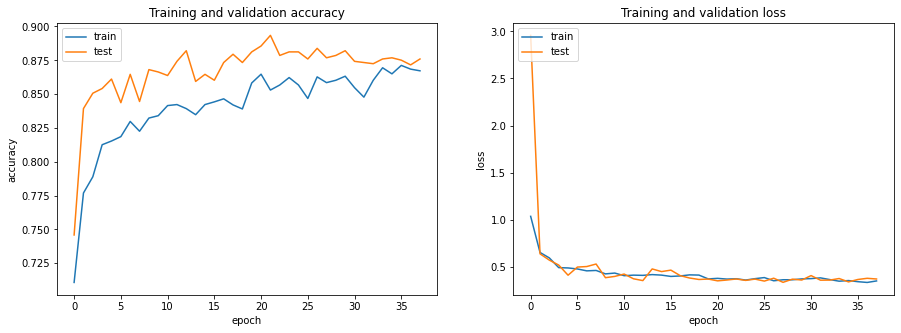

36/36 [==============================] - 8s 216ms/step
              precision    recall  f1-score   support

     Amanita       0.83      0.88      0.86       384
  Armillaria       0.90      0.84      0.87       376
   Hygrocybe       0.90      0.91      0.91       385

    accuracy                           0.88      1145
   macro avg       0.88      0.88      0.88      1145
weighted avg       0.88      0.88      0.88      1145



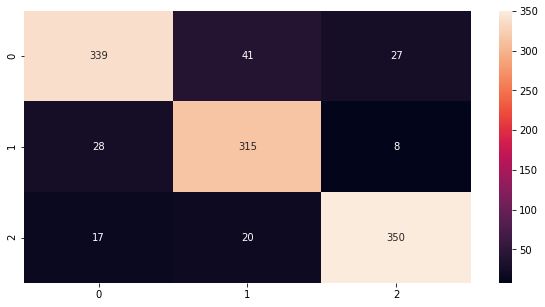

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model, history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "VGG19.h5")

#Xception 

In [ ]:
#Model Configuration

IMG_SIZE=(299,299)

preprocess_input=tf.keras.applications.xception.preprocess_input

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)

base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit
history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

# => on arrive à %

Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/100
126/126 [==============================] - 45s 333ms/step - loss: 1.0558 - accuracy: 0.7123 - val_loss: 0.7132 - val_accuracy: 0.8690
Epoch 2/100
126/126 [==============================] - 40s 317ms/step - loss: 0.6547 - accuracy: 0.7684 - val_loss: 0.6626 - val_accuracy: 0.8271
Epoch 3/100
126/126 [==============================] - 39s 312ms/step - loss: 0.5278 - accuracy: 0.8116 - val_loss: 0.4557 - val_accuracy: 0.8707
Epoch 4/100
126/126 [==============================] - 39s 309ms/step - loss: 0.4995 - accuracy: 0.8218 - val_loss: 0.4505 - val_accuracy: 0.8323
Epoch 5/100
126/126 [==============================] - 40s 317ms/step - loss: 0.4799 - accuracy: 0.8310 - val_loss: 0.3963 - val_accuracy: 0.8655
Epoch 6/100
126/126 [==

18/18 [==============================] - 5s 254ms/step - loss: 0.3158 - accuracy: 0.8953


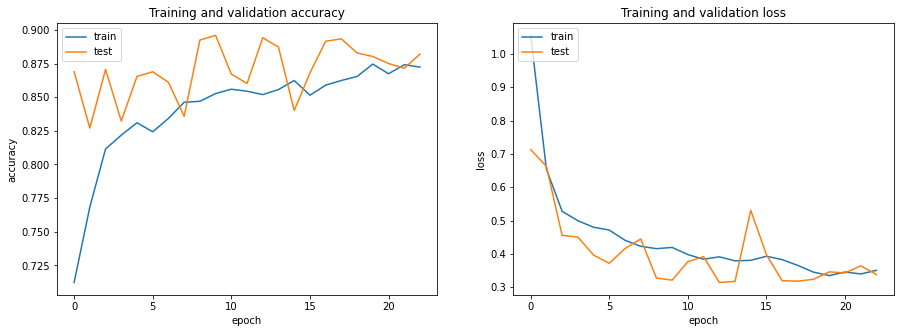

36/36 [==============================] - 9s 240ms/step
              precision    recall  f1-score   support

     Amanita       0.87      0.89      0.88       384
  Armillaria       0.90      0.85      0.88       376
   Hygrocybe       0.91      0.94      0.93       385

    accuracy                           0.89      1145
   macro avg       0.89      0.89      0.89      1145
weighted avg       0.89      0.89      0.89      1145



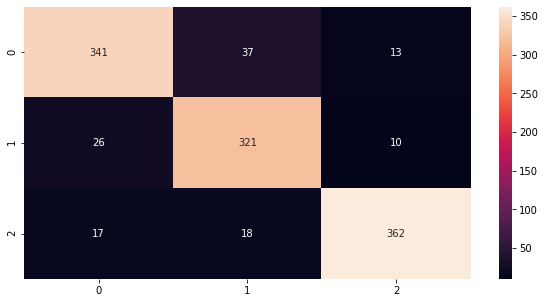

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "xception.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#MobileNet V2

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input= tf.keras.applications.mobilenet_v2.preprocess_input

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit
history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)



Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/100
126/126 [==============================] - 38s 277ms/step - loss: 1.0687 - accuracy: 0.7120 - val_loss: 1.5496 - val_accuracy: 0.7983
Epoch 2/100
126/126 [==============================] - 34s 270ms/step - loss: 0.5564 - accuracy: 0.8033 - val_loss: 0.5372 - val_accuracy: 0.8288
Epoch 3/100
126/126 [==============================] - 33s 262ms/step - loss: 0.5655 - accuracy: 0.8023 - val_loss: 0.5339 - val_accuracy: 0.8428
Epoch 4/100
126/126 [==============================] - 34s 272ms/step - loss: 0.4781 - accuracy: 0.8256 - val_loss: 0.5319 - val_accuracy: 0.8437
Epoch 5/100
126/126 [==============================] - 34s 270ms/step - loss: 0.4712 - accuracy: 0.8251 - val_loss: 0.4630 - val_accuracy: 0.8498
Epoch 6/100
126/126 [====

18/18 [==============================] - 4s 216ms/step - loss: 0.3231 - accuracy: 0.8796


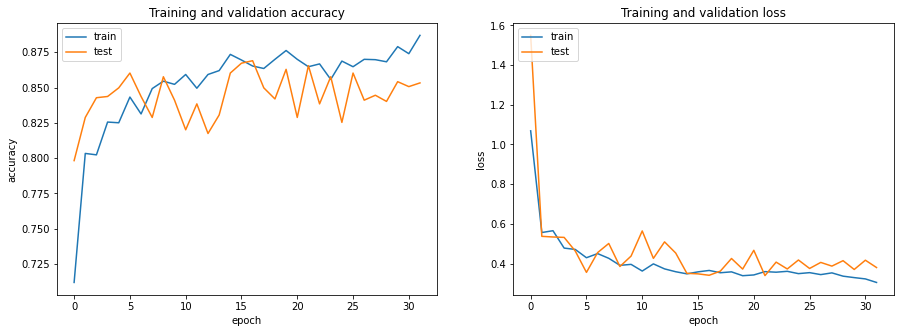

36/36 [==============================] - 8s 212ms/step
              precision    recall  f1-score   support

     Amanita       0.80      0.88      0.84       384
  Armillaria       0.88      0.82      0.85       376
   Hygrocybe       0.92      0.89      0.91       385

    accuracy                           0.87      1145
   macro avg       0.87      0.87      0.87      1145
weighted avg       0.87      0.87      0.87      1145



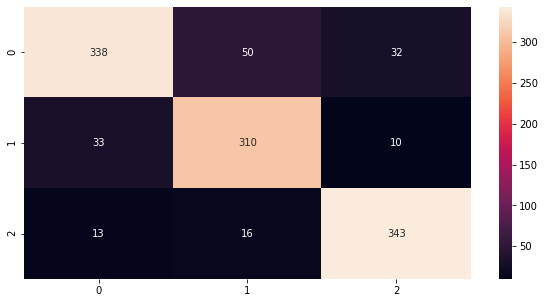

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "MobileNetV2.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#ResNet 50

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=tf.keras.applications.resnet50.preprocess_input

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)
base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])


history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 4007 validated image filenames belonging to 3 classes.
Found 1145 validated image filenames belonging to 3 classes.
Found 573 validated image filenames belonging to 3 classes.
Epoch 1/100
126/126 [==============================] - 48s 297ms/step - loss: 1.3012 - accuracy: 0.6314 - val_loss: 1.4176 - val_accuracy: 0.7808
Epoch 2/100
126/126 [==============================] - 37s 290ms/step - loss: 0.7564 - accuracy: 0.7257 - val_loss: 0.5043 - val_accuracy: 0.8402
Epoch 3/100
126/126 [==============================] - 35s 282ms/step - loss: 0.6698 - accuracy: 0.7564 - val_loss: 1.0993 - val_accuracy: 0.7485
Epoch 4/100
126/126 [==============================] - 36s 288ms/step - loss: 0.5939 - accuracy: 0.7707 - val_loss: 0.4106 - val_accuracy: 0.8472
Epoch 5/100
126/126 [==============================] - 36s 290ms/step - loss: 0.5511 - accuracy: 0.7849 - val_loss: 0.4604 - val_accuracy: 0.8472
Epoch 6/100
126/126 [==============================] - 36s 286ms/step - loss: 0.5382 - a

18/18 [==============================] - 4s 218ms/step - loss: 0.3159 - accuracy: 0.8674


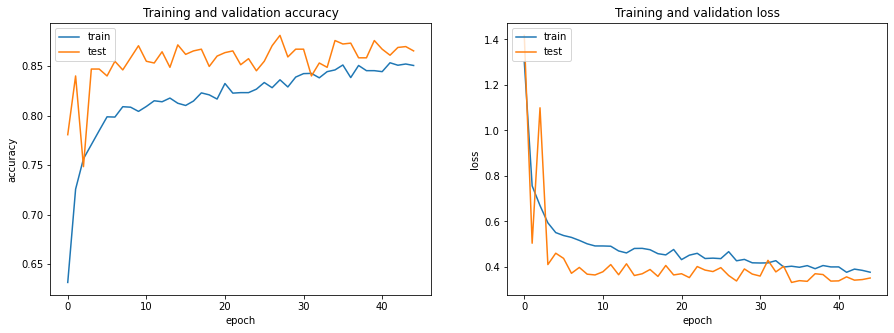

36/36 [==============================] - 10s 225ms/step
              precision    recall  f1-score   support

     Amanita       0.85      0.90      0.87       384
  Armillaria       0.88      0.82      0.85       376
   Hygrocybe       0.91      0.90      0.91       385

    accuracy                           0.88      1145
   macro avg       0.88      0.88      0.88      1145
weighted avg       0.88      0.88      0.88      1145



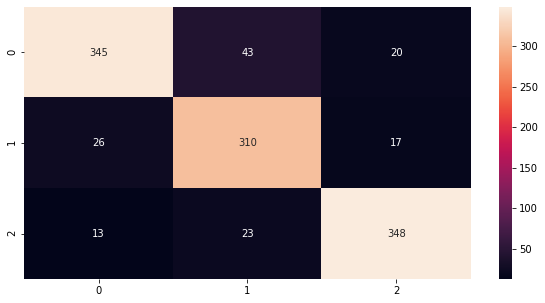

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model, history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/3 genus_2k/" + "ResNet50.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Diagnostics functions

In [ ]:
#show model performance
def show_performance(my_model,history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  x_epochs=range(len(history.history["accuracy"]))
  plt.plot(x_epochs, history.history["accuracy"])
  plt.plot(x_epochs, history.history["val_accuracy"])
  plt.title("Training and validation accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(1,2,2)
  x_epochs=range(len(history.history["loss"]))
  plt.plot(x_epochs, history.history["loss"])
  plt.plot(x_epochs, history.history["val_loss"])
  plt.title("Training and validation loss")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes
  print(metrics.classification_report(y_test_class, test_pred_class, target_names=list_genus))
  df_cm=pd.DataFrame(metrics.confusion_matrix(test_pred_class,y_test_class))
  plt.figure(figsize = (10,5))
  sns.heatmap(df_cm, annot=True, fmt="d")


In [ ]:
def show_good_predictions(preprocess_input):
  
  correct_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] == y_test_class[i]):
      correct_indexes.append(i)

  j=1
  plt.figure(figsize=(10, 10))
  for i in np.random.choice(correct_indexes, size=3):
    img=cv2.imread(X_test.img_path.iloc[i])
    plt.subplot(1,3,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(y_test_class[i]) +
              "\n"+ "Prediction:" + str(test_pred_class[i]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))

In [ ]:
#Show wrong predictions
def show_wrong_predictions(my_model, test_generator):
  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes

  error_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] != y_test_class[i]):
      error_indexes.append(i)
  j=1
  plt.figure(figsize=(15, 10))
  for i in np.random.choice(error_indexes, size=5):
    #img=cv2.imread(X_test.img_path.iloc[i])
    img=tf.io.read_file(test_generator.filenames[i])
    img=tf.image.decode_jpeg(img,channels=3)
    plt.subplot(1,5,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(list_genus[y_test_class[i]]) +
              "\n"+ "Prediction:" + str(list_genus[test_pred_class[i]]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))
    print("Path: ", test_generator.filenames[i])


#SUMMARY

In [ ]:
#list all h5 models in a main directory
def listdirectory2(path): 
    fichier=[] 
    for root, dirs, files in os.walk(path): 
        for i in files:
            full_name= os.path.join(root, i)
            root, extension = os.path.splitext(full_name)
            if extension==".h5": fichier.append(MODEL_DIR + i) 
    return fichier

listdirectory2(MODEL_DIR)

['/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/xception.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb0.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb1.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb2.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb3.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb4.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb5.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb6.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb7.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/vgg16.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/vgg19.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/mobilenetv2.h5',
 '/content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/resnet50.h5']

In [ ]:
#Prepare the image test set for model evaluation

df_genus = pd.read_csv( \
      filepath_or_buffer = WORK_DIR + '/' + "df_genus_2k_clean.csv"
   ,  sep = ','
   ,  header = 0
)

filtre_genus=df_genus.taxon_name.value_counts().index[:3]
print(filtre_genus)
t= df_genus.shape
df_genus=df_genus[df_genus["taxon_name"].isin(filtre_genus)].reset_index()

#Prepare train and test sets
X= df_genus[df_genus["taxon_name"].isin(filtre_genus)][["img_path","taxon_name"]]

#split the dataset between 80% train, 20% validation and 10% test)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
X_train, X_val= train_test_split(X_train, test_size=0.125, random_state=1)

print("shape : ", t)
print("shape X genus: ", X.shape)
print("shape train: ", X_train.shape)
print("shape test:", X_test.shape)
print("shape valid: ", X_val.shape)

X_train.reset_index(drop=True, inplace=True)


Index(['Amanita', 'Hygrocybe', 'Armillaria'], dtype='object')
shape :  (27080, 39)
shape X genus:  (5725, 2)
shape train:  (4007, 2)
shape test: (1145, 2)
shape valid:  (573, 2)


In [ ]:
#load models from file
def load_all_models():
    all_models = {}
    filenames = []
    for root, dirs, files in os.walk(MODEL_DIR): 
        for i in files:
            full_name= os.path.join(root, i)
            root, extension = os.path.splitext(full_name)
            if extension==".h5": filenames.append(MODEL_DIR + i) 
    for file in filenames:
        model = tf.keras.models.load_model(file)
        name = file.replace(MODEL_DIR, "")
        # add to list of members
        all_models[name]=model
        print('>Loading model %s' % file)
    return all_models


# load all models   
members = load_all_models()
print('Loaded %d models' % len(members))

>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/xception.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb0.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb1.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb2.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb3.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb4.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb5.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb6.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/efficientnetb7.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/vgg16.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/3 genus_2k/vgg19.h5
>Loading model /content/drive/MyDrive/work/Ol

In [ ]:

results={}

for name, model in members.items():
    print("\n Analyzing ", name)
    IMG_SIZE= model.input.get_shape().as_list()[1:3]
    if "efficientnet" in name:
        preprocess_input = None
    elif "vgg16" in name:
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
    elif "vgg19" in name:
        preprocess_input = tf.keras.applications.vgg19.preprocess_input
    elif "xception" in name:
        preprocess_input = tf.keras.applications.xception.preprocess_input
    elif "mobilenetv2" in name:
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    elif "resnet" in name:
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
    else : 
        preprocess_input = None

    datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
    #test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
    #                                        x_col="img_path", y_col="taxon_name", shuffle=False,
    #                                        class_mode="sparse", target_size=IMG_SIZE, batch_size=32)
    val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=32)
    # evaluate standalone models on test dataset
    metrics = model.evaluate(val_generator)  #renvoi plusieurs scalars selon le nb de métrique choisies : loss, accuracy,..
    results[name] = metrics
    print('Model Accuracy: %.3f' % metrics[1])

    del model

pd.DataFrame(results, index=["Loss","Accuracy"]).T.drop("Loss", axis=1)


 Analyzing  xception.h5
Found 573 validated image filenames belonging to 3 classes.
18/18 [==============================] - 5s 284ms/step - loss: 0.3158 - accuracy: 0.8953
Model Accuracy: 0.895

 Analyzing  efficientnetb0.h5
Found 573 validated image filenames belonging to 3 classes.
18/18 [==============================] - 4s 232ms/step - loss: 0.2379 - accuracy: 0.9075
Model Accuracy: 0.908

 Analyzing  efficientnetb1.h5
Found 573 validated image filenames belonging to 3 classes.
18/18 [==============================] - 4s 237ms/step - loss: 0.2256 - accuracy: 0.9005
Model Accuracy: 0.901

 Analyzing  efficientnetb2.h5
Found 573 validated image filenames belonging to 3 classes.
18/18 [==============================] - 5s 249ms/step - loss: 0.2499 - accuracy: 0.9197
Model Accuracy: 0.920

 Analyzing  efficientnetb3.h5
Found 573 validated image filenames belonging to 3 classes.
18/18 [==============================] - 5s 277ms/step - loss: 0.2606 - accuracy: 0.9092
Model Accuracy: 0.

,Accuracy
xception.h5,0.895288
efficientnetb0.h5,0.907504
efficientnetb1.h5,0.900524
efficientnetb2.h5,0.919721
efficientnetb3.h5,0.909250
efficientnetb4.h5,0.926702
efficientnetb5.h5,0.923211
efficientnetb6.h5,0.942408
efficientnetb7.h5,0.945899
vgg16.h5,0.916230


Found 573 validated image filenames belonging to 3 classes.
18/18 [==============================] - 31s 1s/step
Path:  /content/drive/MyDrive/work/Oliv/images_clean/Armillaria/276854.jpg
Path:  /content/drive/MyDrive/work/Oliv/images_clean/Hygrocybe/496227.jpg
Path:  /content/drive/MyDrive/work/Oliv/images_clean/Armillaria/934400.jpg
Path:  /content/drive/MyDrive/work/Oliv/images_clean/Armillaria/450340.jpg
Path:  /content/drive/MyDrive/work/Oliv/images_clean/Armillaria/277288.jpg


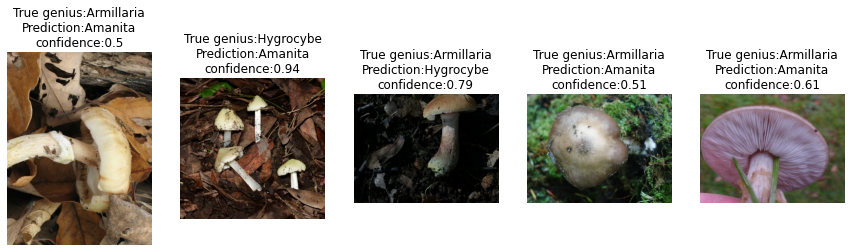

In [ ]:
#Analysis of wrong predictions for one particular model

name = "efficientnetb7.h5"
batch_size=32
model = members[name]
IMG_SIZE = model.input.get_shape().as_list()[1:3]
if "efficientnet" in name:
    preprocess_input = None
elif "vgg16" in name:
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
elif "vgg19" in name:
    preprocess_input = tf.keras.applications.vgg19.preprocess_input
elif "xception" in name:
    preprocess_input = tf.keras.applications.xception.preprocess_input
elif "mobilenetv2" in name:
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
elif "resnet" in name:
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
else : 
    preprocess_input = None
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input) 
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
list_genus=[]
for i,j in val_generator.class_indices.items():
  list_genus.append(i)

show_wrong_predictions(model, val_generator)